## Importing Libraries

In [1]:
import time
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import torch.nn as nn
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional  as f
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import IPython
import torchvision
import numpy as np
import pickle

## Setting Device to GPU for faster training

In [2]:
import torch
print(torch.__version__)

1.10.0+cu113


In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

## Custom Dataset For Testing Images

In [4]:
class SatelliteImagesTrain(Dataset):
    def __init__(self, root_dir_img, root_dir_mask, transform=None):
        self.root_dir_img = root_dir_img
        self.root_dir_mask = root_dir_mask
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.root_dir_img))

    def __getitem__(self, index):
        img_path = os.listdir(self.root_dir_img)[index]
        mask_img_path = os.listdir(self.root_dir_mask)[index]
        sat_img = Image.open(f"{self.root_dir_img}/{img_path}").convert("RGB")
        mask_img = Image.open(f"{self.root_dir_mask}/{mask_img_path}").convert("L")
        
        if self.transform is not None:
            sat_img = self.transform(sat_img)
            mask_img = self.transform(mask_img)

        return (sat_img, mask_img)

## Data Transformation

In [5]:
transform = transforms.Compose([
                               transforms.Resize((512,512)),
                               transforms.ToTensor()
                               ])

In [6]:
test_dataset = SatelliteImagesTrain(root_dir_img = "Bijie-landslide-dataset/landslide/image",root_dir_mask = "Bijie-landslide-dataset/landslide/mask", transform = transform)

## Pretrained Model Architecture [Basenet Used for training landcover classification problem]

In [7]:
class Model(torch.nn.Module):
    def __init__(self, n_classes = 7, channels = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding = 'same')
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, padding = 'same')
        self.dropout2 = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(8, 16, kernel_size=3, padding = 'same')
        self.dropout3 = nn.Dropout(0.2)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv7 = nn.Conv2d(16, 32, kernel_size=3, padding = 'same')
        self.dropout4 = nn.Dropout(0.2)
        self.conv8 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv9 = nn.Conv2d(32, 64, kernel_size=3, padding = 'same')
        self.dropout5 = nn.Dropout(0.2)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=3, padding = 'same')

        self.transConv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(64, 32, kernel_size=3, padding = 'same')
        self.dropout6 = nn.Dropout(0.2)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')

        self.transConv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(32, 16, kernel_size=3, padding = 'same')
        self.dropout7 = nn.Dropout(0.2)
        self.conv14 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')

        self.transConv3 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(16, 8, kernel_size=3, padding = 'same')
        self.dropout8 = nn.Dropout(0.2)
        self.conv16 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')

        self.transConv4 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(8, 4, kernel_size=3, padding = 'same')
        self.dropout9 = nn.Dropout(0.2)
        self.conv18 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')

        self.final_conv = nn.Conv2d(4, n_classes, kernel_size=1, padding = 'same')

    def forward(self, x):
        """ Encoder """
        x1 = nn.ReLU()(self.conv1(x))
        x1 = self.dropout1(x1)
        x1 = nn.ReLU()(self.conv2(x1))
        p1 = self.maxpool1(x1)

        x2 = nn.ReLU()(self.conv3(p1))
        x2 = self.dropout2(x2)
        x2 = nn.ReLU()(self.conv4(x2))
        p2 = self.maxpool2(x2)

        x3 = nn.ReLU()(self.conv5(p2))
        x3 = self.dropout3(x3)
        x3 = nn.ReLU()(self.conv6(x3))
        p3 = self.maxpool3(x3)

        x4 = nn.ReLU()(self.conv7(p3))
        x4 = self.dropout4(x4)
        x4 = nn.ReLU()(self.conv8(x4))
        p4 = self.maxpool4(x4)

        """Transfer block"""
        x5 = nn.ReLU()(self.conv9(p4))
        x5 = self.dropout5(x5)
        x5 = nn.ReLU()(self.conv10(x5))

        """ Decoder """
        u6 = self.transConv1(x5)
        u6 = torch.cat((u6, x4), 1)
        x6 = nn.ReLU()(self.conv11(u6))
        x6 = self.dropout6(x6)
        x6 = nn.ReLU()(self.conv12(x6))

        u7 = self.transConv2(x6)
        u7 = torch.cat((u7, x3), 1)
        x7 = nn.ReLU()(self.conv13(u7))
        x7 = self.dropout7(x7)
        x7 = nn.ReLU()(self.conv14(x7))

        u8 = self.transConv3(x7)
        u8 = torch.cat((u8, x2), 1)
        x8 = nn.ReLU()(self.conv15(u8))
        x8 = self.dropout8(x8)
        x8 = nn.ReLU()(self.conv16(x8))

        u9 = self.transConv4(x8)
        u9 = torch.cat((u9, x1), 1)
        x9 = nn.ReLU()(self.conv17(u9))
        x9 = self.dropout9(x9)
        x9 = nn.ReLU()(self.conv18(x9))

        '''Classifier'''
        output = self.final_conv(x9)
        return f.sigmoid(output)

## Hyperparameter Tuning

In [8]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.001
batch_size = 32
shuffle = True
pin_memory = True
num_workers = 0

## DataLoader

In [9]:
test_loader = DataLoader(dataset=test_dataset, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

## Loading the pretrained model, setting the loss to MSE and modifying last year to do binary mask genearation

In [10]:
model = torch.load("Models and saves/model_extend.pt").to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
model.conv1.weight.requires_grad = False
model.conv2.weight.requires_grad = False
model.conv3.weight.requires_grad = False
model.conv4.weight.requires_grad = False
model.conv5.weight.requires_grad = False
model.conv6.weight.requires_grad = False
model.conv7.weight.requires_grad = False
model.conv8.weight.requires_grad = False
model.conv9.weight.requires_grad = False
model.conv10.weight.requires_grad = False
model.conv11.weight.requires_grad = False
model.conv12.weight.requires_grad = False
model.conv13.weight.requires_grad = False
model.conv14.weight.requires_grad = False
model.conv15.weight.requires_grad = False
model.conv16.weight.requires_grad = False
model.conv17.weight.requires_grad = False
model.conv18.weight.requires_grad = False

model.transConv1.weight.requires_grad = False
model.transConv2.weight.requires_grad = False
model.transConv3.weight.requires_grad = False
model.transConv4.weight.requires_grad = False

model.final_conv = nn.Conv2d(4, 1, kernel_size=1, padding = 'same').to(device)

## Training Loop

In [12]:
epoch_loss_list = []
loop = tqdm(range(num_epochs),total = num_epochs)
for epoch in loop:
    epoch_loss = 0
    for sat_img, mask_img in test_loader:
        # Forward Propagation:
        sat_img = sat_img.to(device)
        mask_img = mask_img.to(device)
        output = model(sat_img)
        # Backward Propagation:
        loss = criterion(output, mask_img)
        epoch_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix({"Loss_batch":loss.item()})
    epoch_loss_list.append(epoch_loss/(len(test_loader) / batch_size))
    loop.set_postfix({"Loss_Epoch":epoch_loss/(len(test_loader) / batch_size)})

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Python39\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Saving Model

In [13]:
torch.save(model,"landslide_pretrained.pt")

## Checking predictions against masks

In [14]:
for i,j in test_loader:
    i = i.to(device)
    j = j.to(device)
    output = model(i)
    break

In [15]:
# source: https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [16]:
grid_imgs = torchvision.utils.make_grid(i, nrow=4)

In [17]:
grid_imgs_2 = torchvision.utils.make_grid(j, nrow=4)

In [18]:
grid_imgs_3 = torchvision.utils.make_grid(output, nrow=4)

## Satellite Images of Landslide regions

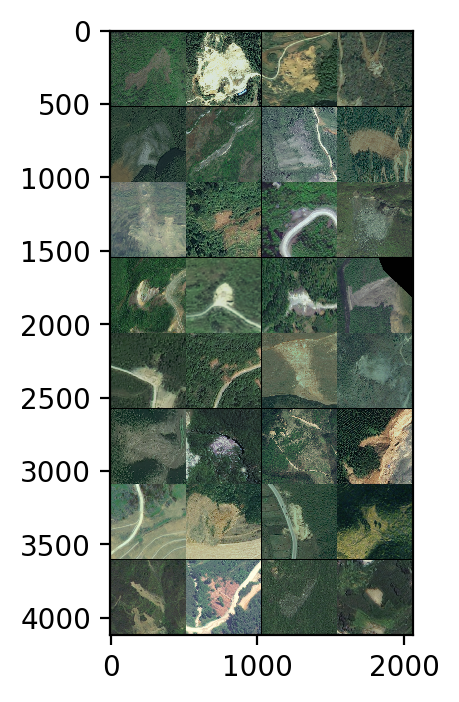

In [19]:
f = plt.figure(dpi=200)
show(grid_imgs)

## True Labels

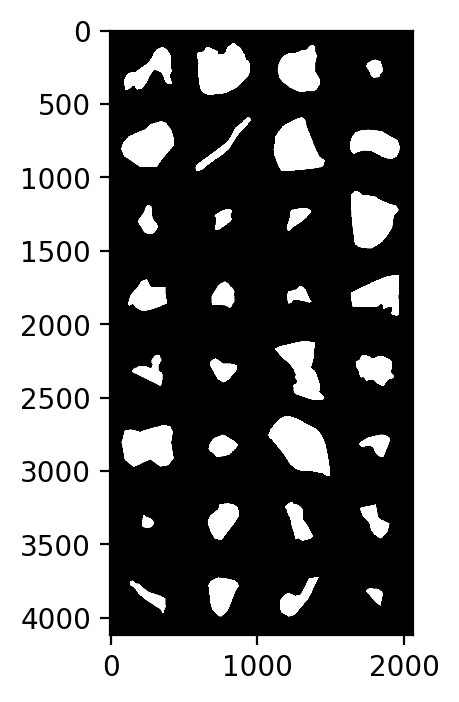

In [20]:
f = plt.figure(dpi=200)
show(grid_imgs_2)

## Predicted Masks

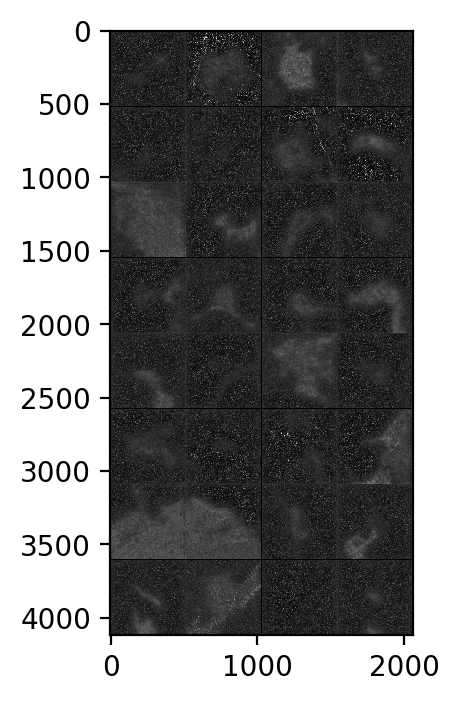

In [21]:
f = plt.figure(dpi=200)
show(grid_imgs_3)